# 第8章 高性能的Python

> 许多高性能库可以用于加速Python代码的执行：
    * Cython 用于合并Py由on和C语言静态编译范型。
    * IPython.parallel 用于在本地或者在群集上并行执行代码／函数。
    * numexpr 用于快速数值运算。
    * multiprocessing Python内建的（本地）并行处理模块。
    * Numba 用于为CPU动态编译Python代码。
    * NumbaPro 用于为多核CPU和GPU动态编译Python代码。

## 8.1 Python范型与性能

In [1]:
def perf_comp_data(func_list, data_list, rep=3, number=1):
    """
    Function to compare the performance of different function.
    :param func_list: list with function names as strings
    :param data_list: list with data set names as strings
    :param rep: number of repetitions of the whole comparison
    :param number: number of executions for every function
    :return:
    """
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' + data_list[name[0]]
        results = repeat(stmt=stmt, setup=setup, repeat=rep, number=number)
        res_list[name[1]] = sum(results) / rep
    res_sort = sorted(res_list.items(), key=lambda item: item[1])
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print('function:' + item[0] + ', av.item sec: %9.5f, ' % item[1] + 'relative: %6.1f' % rel)


# 8.1 Python范型与性能

from math import *


# 很容易转换为一个Python函数
def f(x):
    return abs(cos(x)) ** 0.5 + sin(2 + 3 * x)

# 使用range函数，我们可以高效地生成一个包含 50 万个数值的列表对象
I = 500000
a_py = range(I)

# 包含显式循环的标准Python函数
def f1(a):
    res = []
    for x in a:
        res.append(f(x))
    return res

# 包含隐含循环的迭代子方法
def f2(a):
    return [f(x) for x in a]

# 包含隐含循环、使用eval的选代子方法
def f3(a):
    ex = 'abs(cos(x))**0.5+sin(2+3*x)'
    return [eval(ex) for x in a]

# Numy向量化实现
import numpy as np
a_np = np.arange(I)
def f4(a):
    return (np.abs(np.cos(a)) ** 0.5 + np.sin(2 + 3 * a))

# 专用库numexpr求数值表达式的值。 这个库内建了多线程执行支持
# numexpr单线程实现
import numexpr as ne
def f5(a):
    ex='abs(cos(a))**0.5+sin(2+3*a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

# nwexpr多线程实现
def f6(a):
    ex = 'abs(cos(a))**0.5+sin(2+3*a)'
    ne.set_num_threads(16)
    return ne.evaluate(ex)


r1=f1(a_py)
r2=f2(a_py)
r3=f3(a_py)
r4=f4(a_np)
r5=f5(a_np)
r6=f6(a_np)
# Wall time: 35.1 s

# NumPy函数alJclose可以轻松地检查两个（类） ndarray对象是否包含相同数据
np.allclose(r1,r2)
# True
np.allclose(r1,r3)
# True
np.allclose(r1,r4)
# True
np.allclose(r1,r5)
# True
np.allclose(r1,r6)
# True

# 使用perf_comp_data函数
func_list=['f1','f2','f3','f4','f5','f6']
data_list=['a_py','a_py','a_py','a_np','a_np','a_np']
perf_comp_data(func_list,data_list)
# function:f6, av.item sec:   0.01623, relative:    1.0
# function:f5, av.item sec:   0.04650, relative:    2.9
# function:f4, av.item sec:   0.07293, relative:    4.5
# function:f2, av.item sec:   1.17137, relative:   72.2
# function:f1, av.item sec:   1.33291, relative:   82.1
# function:f3, av.item sec:  33.47790, relative: 2062.2

function:f6, av.item sec:   0.00281, relative:    1.0
function:f5, av.item sec:   0.00906, relative:    3.2
function:f4, av.item sec:   0.01905, relative:    6.8
function:f2, av.item sec:   0.21946, relative:   78.0
function:f1, av.item sec:   0.24586, relative:   87.3
function:f3, av.item sec:   6.22748, relative: 2212.5


## 内存布局与性能

In [2]:
import numpy as np
np.zeros((3,3),dtype=np.float64,order='C')
# array([[ 0.,  0.,  0.],
#        [ 0.,  0.,  0.],
#        [ 0.,  0.,  0.]])

# 元素在内存中存储的顺序：C表示类似C（行优先）
c=np.array([[1.,1.,1.],
            [2.,2.,2.],
            [3.,3.,3.]],order='C')
# F表示类似Fortran （列优先）
f=np.array([[1.,1.,1.],
            [2.,2.,2.],
            [3.,3.,3.]],order='F')

x = np.random.standard_normal((3, 1500000))
C = np.array(x, order='C')
F = np.array(x, order='F')
x = 0.0

%timeit C.sum(axis=0)  # 10 loops, best of 3: 19.3 ms per loop
%timeit C.sum(axis=1)  # 100 loops, best of 3: 10.3 ms per loop
# 第一个轴上计算总和比第二个轴慢了将近一倍
%timeit C.std(axis=0)  # 10 loops, best of 3: 112 ms per loop
%timeit C.std(axis=1)  # 10 loops, best of 3: 57.6 ms per loop

%timeit F.sum(axis=0)  # 10 loops, best of 3: 70.7 ms per loop
%timeit F.sum(axis=1)  # 10 loops, best of 3: 84.2 ms per loop
# 两个轴的相对差值并不太大
%timeit F.std(axis=0)  # 1 loop, best of 3: 253 ms per loop
%timeit F.std(axis=1)  # 1 loop, best of 3: 227 ms per loop

# 与类似C的布局相比， 类似F这种布局的性能更差


6.11 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.98 ms ± 82.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.3 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.5 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.1 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.9 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.5 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.9 ms ± 682 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 8.3 并行计算

### 8.3.1 蒙特卡洛算法

In [3]:
def bsm_mcs_valuation(strike):
    """
    Dynamic Black-Scholes-Merton Monte Carlo estimator for European calls.
    :param strike:
    :return:
    """
    import numpy as np
    S0=100.;T=1.0;r=0.05;vola=0.2
    M=50;I=2000
    dt=T/M
    rand=np.random.standard_normal((M+1,I))
    S=np.zeros((M+1,I));S[0]=S0
    for t in range(1,M+1):
        S[t]=S[t-1]*np.exp((r-0.5*vola**2)*dt+vola*np.sqrt(dt)*rand[t])
    value=(np.exp(-r*T)*np.sum(np.maximum(S[-1]-strike,0))/I)
    return value

### 8.3.2 顺序化计算

CPU times: user 332 ms, sys: 2.31 ms, total: 334 ms
Wall time: 333 ms


Text(0, 0.5, 'European call option values')

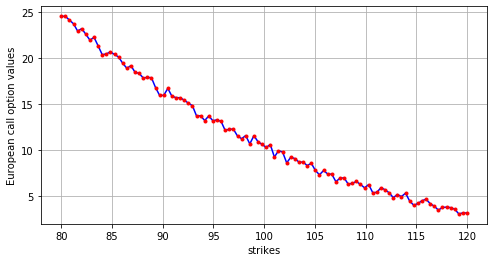

In [4]:
def seq_value(n):
    """
    Sequential option valuation
    :param n: number of option valuations/strikes
    :return:
    """
    strikes=np.linspace(80,120,n)
    option_values=[]
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes,option_values

n=100 # number of options to be valued
%time strikes,option_values_seq=seq_value(n)
# Wall time: 1.39 s

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(strikes,option_values_seq,'b')
plt.plot(strikes,option_values_seq,'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

## 8.4 多处理

In [ ]:
import numpy as np
import multiprocessing as mp
import math
import matplotlib.pyplot as plt
def simulate_geometric_brownian_motion(p):
    M,I=p
    # time steps,paths
    S0=100;r=0.05;sigma=0.2;T=1.0
    # model parameters
    dt=T/M
    paths=np.zeros((M+1,I))
    paths[0]=S0
    for t in range(1,M+1):
        paths[t]=paths[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*np.random.standard_normal(I))
    return paths

paths=simulate_geometric_brownian_motion((5,2))
print(paths)
# array([[ 100.        ,  100.        ],
#        [  98.75585496,   86.36316092],
#        [ 109.5045796 ,   82.00664539],
#        [  92.85348223,   81.23649105],
#        [  73.79002067,   81.99661207],
#        [  67.4225339 ,   89.39928928]])

if __name__ == '__main__':
    I=10000  # number of paths
    M=100  # number of time steps
    t=100  # number of tasks/simulations
    # running on server with 8 cores/16 threads
    from time import time
    times=[]
    for w in range(1,17):
        t0=time()
        pool=mp.Pool(processes=w)
        # the pool of workers
        result = pool.map(simulate_geometric_brownian_motion,t*[(M,I),])
        # the mapping of the function to the list of parameter tuples
        times.append(time()-t0)

    plt.plot(range(1, 17), times)
    plt.plot(range(1, 17), times, 'ro')
    plt.grid(True)
    plt.xlabel('number of processes')
    plt.ylabel('time in seconds')
    plt.title('%d Monte Carlo simulations' % t)

[[100.         100.        ]
 [ 91.94084739  94.53682889]
 [ 85.6764648   80.1533799 ]
 [ 88.63429712  72.21761107]
 [ 87.7624879   67.37582274]
 [ 84.64830338  69.26316996]]


## 8.5 动态编译

### 8.5.1 介绍性示例

In [6]:
from math import cos,log
def f_py(I,J):
    res=0
    for i in range(I):
        for j in range(J):
            res+=int(cos(log(1)))
    return res

I,J=5000,5000
%time f_py(I,J)
# Wall time: 30 s
# 25000000

def f_np(I, J):
    a = np.ones((I, J), dtype=np.float64)
    return int(np.sum(np.cos(np.log(a)))), a

%time res, a = f_np(I, J)
# Wall time: 1.34 s

a.nbytes
# 200000000

import numba as nb
f_nb=nb.jit(f_py)

%time f_nb(I,J)
# Wall time: 741 ms
# 25000000

func_list=['f_py','f_np','f_nb']
data_list=3*['I,J']
perf_comp_data(func_list,data_list)

# function:f_nb, av.item sec:   0.00001, relative:    1.0
# function:f_np, av.item sec:   1.36470, relative: 156714.8
# function:f_py, av.item sec:  29.53817, relative: 3391993.0

CPU times: user 9.48 s, sys: 6.04 s, total: 15.5 s
Wall time: 14.9 s
CPU times: user 453 ms, sys: 683 ms, total: 1.14 s
Wall time: 784 ms
CPU times: user 1.58 s, sys: 5.7 s, total: 7.27 s
Wall time: 6.83 s
function:f_nb, av.item sec:   0.00000, relative:    1.0
function:f_np, av.item sec:   0.79060, relative: 464600.7
function:f_py, av.item sec:  12.19503, relative: 7166519.7


### 8.5.2 二项式期权定价方法

## 8.6 用Cython进行静态编译

## 8.7 在GPU上生成随机数